In [12]:
from py import nets
import torch
from py.utils import get_default_device, imshow
from py.train import train_mnist, test, test_on_attack
from torch import optim
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch import optim
from py.train import train_mnist, train_with_validation
from py.nets import CIFARModel
from py import utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import numpy as np
from algo.variable_optim import VSGD
from py import nets, utils, train
from torch import optim
import os.path
 
import matplotlib.pyplot as plt
%matplotlib inline

n_epochs = 30
batch_size = 64
learning_rate = 0.01
momentum = 0.9
num_workers=4

# Specifiy the variabilities to be be trained on for the VSGD algorithm

In [13]:
variabilities = [0.1, 0.0015, 0.01, 0.002, 0.005]

# Prepare train and validation loaders

In [14]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

MEAN = [0.49139968, 0.48215841, 0.44653091]
STD  = [0.24703223, 0.24348513, 0.26158784]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

n_epochs = 30
batch_size = 64
learning_rate = 0.01
momentum = 0.9
num_workers=4

# Proportion of training set to use as validation
validation_size = 0.2

train_data = datasets.CIFAR10('./datasets', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('./datasets', train=False, download=True, transform=transform)

# Obtain training indexs that will be used for training and validation loaders
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(validation_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare dataloaders with train and valid samplers
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


# Train Base Model

In [15]:
base_model = nets.CIFARModel()
device = utils.get_default_device()
base_model.to(device)

# specify optimizer
sgd_optim = optim.SGD(base_model.parameters(), lr=learning_rate, momentum=momentum)

train_losslist, valid_losslist = train_with_validation(base_model, sgd_optim, train_loader, valid_loader, device, classes, n_epochs=n_epochs)
torch.save(base_model.state_dict(),"./models/base_cifar.pt")

  0%|          | 0/4710 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.585709 	Validation Loss: 0.328848
Validation loss decreased (inf --> 0.328848).  Saving model ...
Epoch: 2 	Training Loss: 1.104149 	Validation Loss: 0.241271
Validation loss decreased (0.328848 --> 0.241271).  Saving model ...
Epoch: 3 	Training Loss: 0.880009 	Validation Loss: 0.211591
Validation loss decreased (0.241271 --> 0.211591).  Saving model ...
Epoch: 4 	Training Loss: 0.738817 	Validation Loss: 0.182225
Validation loss decreased (0.211591 --> 0.182225).  Saving model ...
Epoch: 5 	Training Loss: 0.635542 	Validation Loss: 0.183968
Epoch: 6 	Training Loss: 0.545183 	Validation Loss: 0.173751
Validation loss decreased (0.182225 --> 0.173751).  Saving model ...
Epoch: 7 	Training Loss: 0.470039 	Validation Loss: 0.165668
Validation loss decreased (0.173751 --> 0.165668).  Saving model ...
Epoch: 8 	Training Loss: 0.387493 	Validation Loss: 0.176037
Epoch: 9 	Training Loss: 0.329655 	Validation Loss: 0.193200
Epoch: 10 	Training Loss: 0.272374 	Valida

30
[1.5857092805480957, 1.1041489790344239, 0.880008833694458, 0.7388174639892578, 0.6355419869995117, 0.5451831252288818, 0.47003886573791503, 0.38749284851074217, 0.32965544088363646, 0.2723742058563232, 0.22765276593208314, 0.19009262511253358, 0.17172928764343262, 0.1432314483475685, 0.13181052635192872, 0.11915607685089111, 0.10618808075428009, 0.09231512966752052, 0.08896913398742676, 0.09114507666707039, 0.07210340734541416, 0.0710466730311513, 0.0551821997334063, 0.05608214034102857, 0.0587760595472157, 0.047733803695887325, 0.053604069656729696, 0.04342708705157042, 0.04426295657359064, 0.05528488541081548]


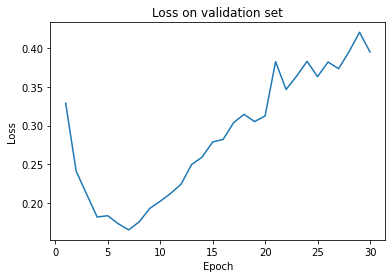

In [16]:
print(n_epochs)
print(train_losslist)
epoch_list = list(range(1, n_epochs+1))
plt.plot(epoch_list, valid_losslist)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Loss on validation set")
plt.savefig('./plots/validation_loss_cifar.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
for var in variabilities:
    print(f"Training vsgd with var {var}")
    vsgd_model = nets.CIFARModel()
    vsgd_model.to(device)
    # specificy optimizer
    vsgd_optim = VSGD(vsgd_model.parameters(), variability=var, lr=learning_rate, momentum=momentum)
    v_train_losslist, v_valid_losslist = train_with_validation(vsgd_model, vsgd_optim, train_loader, valid_loader, device, classes)
    save_dir = f"./models/vsgd_cifar_{var:.1e}.pt"
    print(f"Saving at {save_dir}")
    torch.save(vsgd_model.state_dict(), save_dir)

  0%|          | 0/4710 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.913106 	Validation Loss: 0.463052
Validation loss decreased (inf --> 0.463052).  Saving model ...
Epoch: 2 	Training Loss: 1.846525 	Validation Loss: 0.460903
Validation loss decreased (0.463052 --> 0.460903).  Saving model ...
Epoch: 3 	Training Loss: 1.845757 	Validation Loss: 0.461031
Epoch: 4 	Training Loss: 1.846878 	Validation Loss: 0.461484
Epoch: 5 	Training Loss: 1.845993 	Validation Loss: 0.461320
Epoch: 6 	Training Loss: 1.846006 	Validation Loss: 0.463282
Epoch: 7 	Training Loss: 1.845662 	Validation Loss: 0.461940
Epoch: 8 	Training Loss: 1.846472 	Validation Loss: 0.460528
Validation loss decreased (0.460903 --> 0.460528).  Saving model ...
Epoch: 9 	Training Loss: 1.846212 	Validation Loss: 0.461463
Epoch: 10 	Training Loss: 1.846169 	Validation Loss: 0.462007
Epoch: 11 	Training Loss: 1.846309 	Validation Loss: 0.461486
Epoch: 12 	Training Loss: 1.845639 	Validation Loss: 0.462989
Epoch: 13 	Training Loss: 1.845778 	Validation Loss: 0.461494
E

  0%|          | 0/4710 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.585729 	Validation Loss: 0.315422
Validation loss decreased (inf --> 0.315422).  Saving model ...
Epoch: 2 	Training Loss: 1.089532 	Validation Loss: 0.236859
Validation loss decreased (0.315422 --> 0.236859).  Saving model ...
Epoch: 3 	Training Loss: 0.877362 	Validation Loss: 0.204209
Validation loss decreased (0.236859 --> 0.204209).  Saving model ...
Epoch: 4 	Training Loss: 0.736195 	Validation Loss: 0.180715
Validation loss decreased (0.204209 --> 0.180715).  Saving model ...
Epoch: 5 	Training Loss: 0.635913 	Validation Loss: 0.175331
Validation loss decreased (0.180715 --> 0.175331).  Saving model ...
Epoch: 6 	Training Loss: 0.546401 	Validation Loss: 0.167630
Validation loss decreased (0.175331 --> 0.167630).  Saving model ...
Epoch: 7 	Training Loss: 0.472745 	Validation Loss: 0.182620
Epoch: 8 	Training Loss: 0.395851 	Validation Loss: 0.188095
Epoch: 9 	Training Loss: 0.329246 	Validation Loss: 0.181939
Epoch: 10 	Training Loss: 0.276187 	Valida

  0%|          | 0/4710 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.659550 	Validation Loss: 0.332060
Validation loss decreased (inf --> 0.332060).  Saving model ...
Epoch: 2 	Training Loss: 1.166449 	Validation Loss: 0.269622
Validation loss decreased (0.332060 --> 0.269622).  Saving model ...
Epoch: 3 	Training Loss: 0.939248 	Validation Loss: 0.216314
Validation loss decreased (0.269622 --> 0.216314).  Saving model ...
Epoch: 4 	Training Loss: 0.783826 	Validation Loss: 0.193509
Validation loss decreased (0.216314 --> 0.193509).  Saving model ...
Epoch: 5 	Training Loss: 0.675047 	Validation Loss: 0.176738
Validation loss decreased (0.193509 --> 0.176738).  Saving model ...
Epoch: 6 	Training Loss: 0.591216 	Validation Loss: 0.179895
Epoch: 7 	Training Loss: 0.520181 	Validation Loss: 0.172896
Validation loss decreased (0.176738 --> 0.172896).  Saving model ...
Epoch: 8 	Training Loss: 0.452195 	Validation Loss: 0.164906
Validation loss decreased (0.172896 --> 0.164906).  Saving model ...
Epoch: 9 	Training Loss: 0.390989 

  0%|          | 0/4710 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.575988 	Validation Loss: 0.322471
Validation loss decreased (inf --> 0.322471).  Saving model ...
Epoch: 2 	Training Loss: 1.107993 	Validation Loss: 0.249113
Validation loss decreased (0.322471 --> 0.249113).  Saving model ...
Epoch: 3 	Training Loss: 0.890450 	Validation Loss: 0.215148
Validation loss decreased (0.249113 --> 0.215148).  Saving model ...
Epoch: 4 	Training Loss: 0.750028 	Validation Loss: 0.188610
Validation loss decreased (0.215148 --> 0.188610).  Saving model ...
Epoch: 5 	Training Loss: 0.639543 	Validation Loss: 0.170396
Validation loss decreased (0.188610 --> 0.170396).  Saving model ...
Epoch: 6 	Training Loss: 0.550936 	Validation Loss: 0.169858
Validation loss decreased (0.170396 --> 0.169858).  Saving model ...
Epoch: 7 	Training Loss: 0.469260 	Validation Loss: 0.181374
Epoch: 8 	Training Loss: 0.396215 	Validation Loss: 0.171261
Epoch: 9 	Training Loss: 0.332667 	Validation Loss: 0.182931
Epoch: 10 	Training Loss: 0.268856 	Valida

  0%|          | 0/4710 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.577900 	Validation Loss: 0.318317
Validation loss decreased (inf --> 0.318317).  Saving model ...
Epoch: 2 	Training Loss: 1.109237 	Validation Loss: 0.253839
Validation loss decreased (0.318317 --> 0.253839).  Saving model ...
Epoch: 3 	Training Loss: 0.909128 	Validation Loss: 0.214508
Validation loss decreased (0.253839 --> 0.214508).  Saving model ...
Epoch: 4 	Training Loss: 0.756833 	Validation Loss: 0.199678
Validation loss decreased (0.214508 --> 0.199678).  Saving model ...
Epoch: 5 	Training Loss: 0.656756 	Validation Loss: 0.176376
Validation loss decreased (0.199678 --> 0.176376).  Saving model ...
Epoch: 6 	Training Loss: 0.564184 	Validation Loss: 0.169736
Validation loss decreased (0.176376 --> 0.169736).  Saving model ...
Epoch: 7 	Training Loss: 0.482353 	Validation Loss: 0.171148
Epoch: 8 	Training Loss: 0.411077 	Validation Loss: 0.178275
Epoch: 9 	Training Loss: 0.352878 	Validation Loss: 0.190158
Epoch: 10 	Training Loss: 0.285168 	Valida

In [20]:
vsgd_model.load_state_dict(torch.load(f"./models/vsgd_cifar_5.0e-03.pt"))
acc = test(vsgd_model, test_loader, device, classes, show_class_accs=True)
print(f"Robust acc: {acc:.2f}")

  0%|          | 0/157 [00:00<?, ?it/s]

	Accuracy for class: airplane is 65.2 %
	Accuracy for class: automobile is 80.5 %
	Accuracy for class: bird is 52.8 %
	Accuracy for class: cat is 41.1 %
	Accuracy for class: deer is 64.9 %
	Accuracy for class: dog is 65.2 %
	Accuracy for class: frog is 84.0 %
	Accuracy for class: horse is 80.7 %
	Accuracy for class: ship is 89.3 %
	Accuracy for class: truck is 82.1 %
Robust acc: 70.58


# Plot test loss

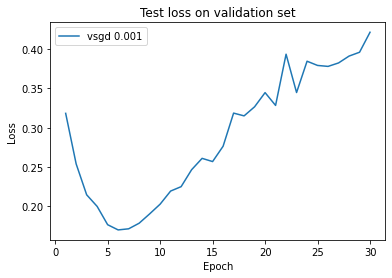

1e-03


In [21]:
epoch_list = list(range(1, n_epochs+1))
#plt.plot(epoch_list, valid_losslist, label="sgd")
plt.plot(epoch_list, v_valid_losslist, label="vsgd 0.001")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc='upper left')
plt.title("Test loss on validation set")
plt.savefig('./plots/validation_loss_cifar.png', dpi=300, bbox_inches='tight')
plt.show()
scientific_notation=f"{0.001:.0e}"
print(scientific_notation)